In [6]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

def extract_hyperparams(file_path):
    dir_name = os.path.dirname(file_path)
    config_name = os.path.basename(dir_name)
    params = {}

    bs_match = re.search(r'bs(\d+)', config_name)
    if bs_match:
        params['batch_size'] = int(bs_match.group(1))

    lr_match = re.search(r'lr([\d\.]+)', config_name)
    if lr_match:
        params['learning_rate'] = float(lr_match.group(1))

    kd_match = re.search(r'kd([\d\.]+)', config_name)
    if kd_match:
        params['kd_ratio'] = float(kd_match.group(1))

    g_match = re.search(r'G(\d+)', config_name)
    if g_match:
        params['grad_accum'] = int(g_match.group(1))

    return params

def parse_log_file(file_path):
    train_data = []
    eval_metrics_list = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            parts = [p.strip() for p in line.split("|")]
            if parts[0] == "dev":
                eval_metrics = {"avg_loss": float(parts[1].split(":")[1].strip())}
                metrics = eval(parts[2])
                eval_metrics["rougeL"] = metrics["rougeL"]
                eval_metrics["exact_match"] = metrics["exact_match"]
                eval_metrics_list.append(eval_metrics)
            elif parts[0] == "train":
                epoch = int(parts[1].split()[1])
                iteration = int(parts[2].split()[1].split("/")[0])
                loss = float(parts[4].split(":")[1].strip())
                ds_loss = float(parts[5].split(":")[1].strip())
                train_data.append((epoch, iteration, loss, ds_loss))

    return train_data, eval_metrics_list

def format_label(params):
    return f"LR={params['learning_rate']} BS={params['batch_size']} KD={params['kd_ratio']} GradAcc={params['grad_accum']}"

def plot_training_loss(ax, train_data_list, params_list, labels):
    for train_data, params, label in zip(train_data_list, params_list, labels):
        iterations = [entry[1] for entry in train_data]
        losses = [entry[2] for entry in train_data]
        ds_losses = [entry[3] for entry in train_data]
        ax.plot(iterations, losses, marker='o', linestyle='-', label=label)
    ax.set_title("Training Loss", fontsize = 16)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_ylim(0, 5)
    ax.legend()

def plot_eval_metric(ax, eval_metrics_list, params_list, metric_name, label,   labels, step_interval=5000):
    for eval_metrics, params,  lbl in zip(eval_metrics_list, params_list,   labels):
        eval_steps = [step_interval * i for i in range(len(eval_metrics))]
        values = [metrics[metric_name] for metrics in eval_metrics]
        ax.plot(eval_steps, values, marker='o', linestyle='-', label=lbl)
    ax.set_title(label,fontsize=16)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(label)
    ax.legend()
    ax.set_ylim(0, 70)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


import matplotlib.pyplot as plt

def plot_results(file_paths, title=None, custom_labels=None):
    params_list = [extract_hyperparams(fp) for fp in file_paths]

    # Use custom labels if provided
    if custom_labels:
        labels = custom_labels
    else:
        labels = [format_label(params) for params in params_list]

    train_data_list = []
    eval_metrics_list = []

    for file_path in file_paths:
        train_data, eval_metrics = parse_log_file(file_path)
        train_data_list.append(train_data)
        eval_metrics_list.append(eval_metrics)

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 fila, 3 columnas

    if title:
        fig.suptitle(title, fontsize=20, fontweight='bold', y=1.05)

    plot_training_loss(axes[0], train_data_list, params_list, labels)
    plot_eval_metric(axes[1], eval_metrics_list, params_list, 'avg_loss', 'Avg Loss', labels)
    plot_eval_metric(axes[2], eval_metrics_list, params_list, 'rougeL', 'ROUGE-L', labels)

    plt.tight_layout()
    plt.show()



# KD Ratio

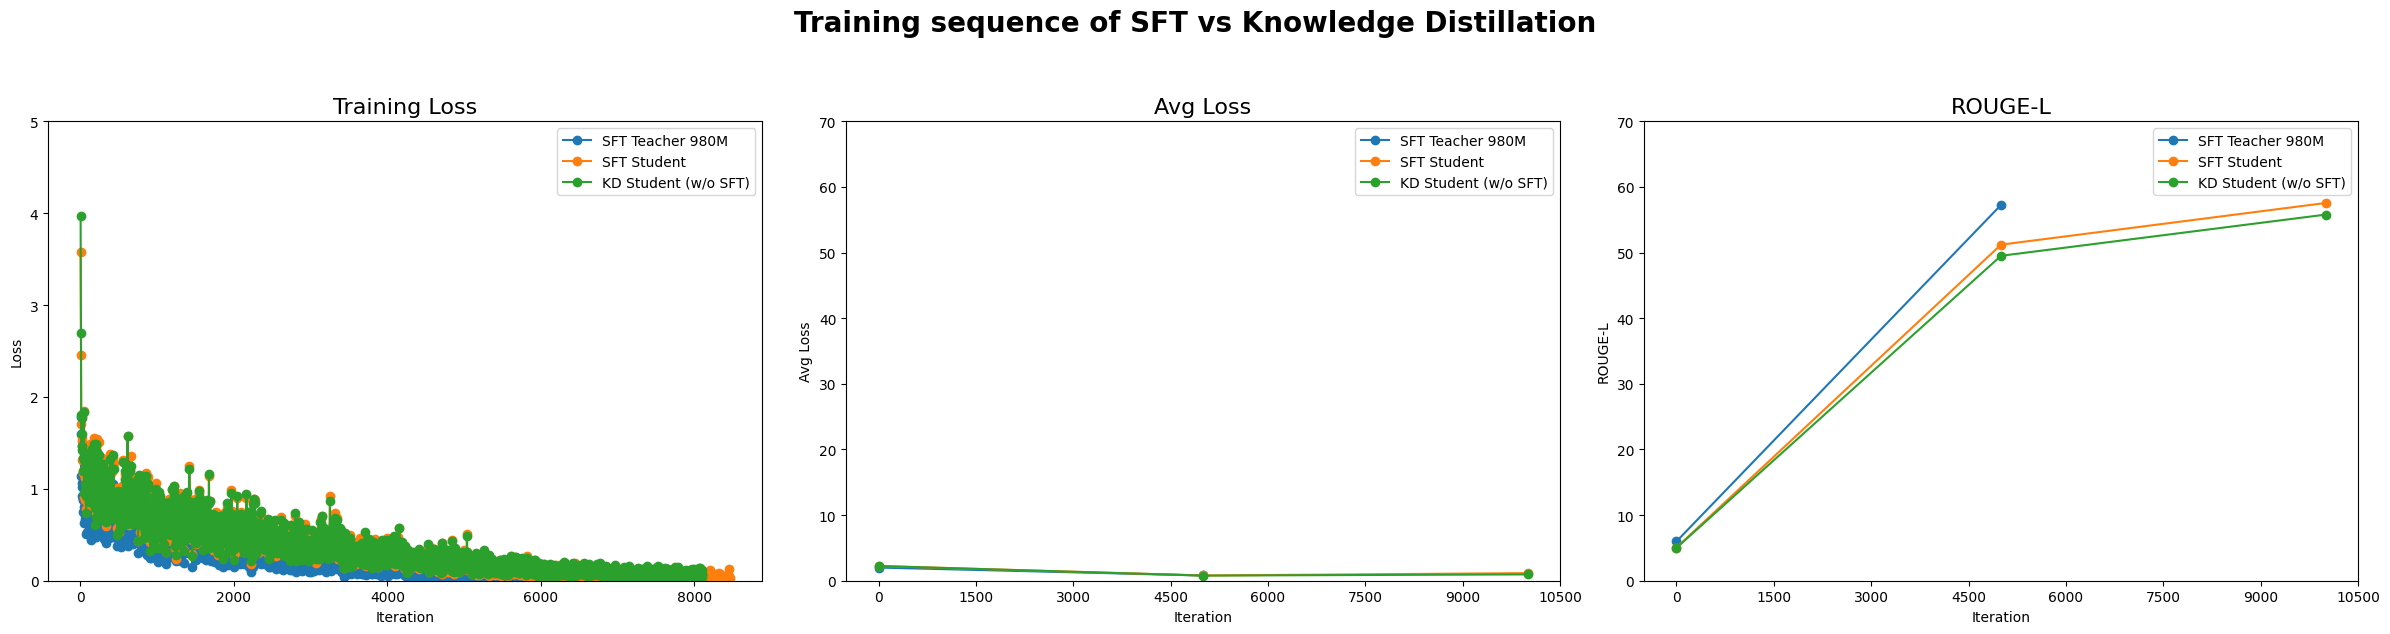

In [ ]:
file_paths = [
    "./results/gpt2/train/sft/gpt2-large/log.txt",
    #"./results/gpt2/train/sft/gpt2-xlarge/e10-bs2-lr5e-05-G1-N4-NN1/log.txt",  # Teacher
    "./results/gpt2/train/sft/gpt2-base/e10-bs2-lr0.0005-G1-N1-NN1/log.txt",    # Student SFT
    "./results/gpt2/train/kd/e10-bs2-lr0.0005-G1-N1-NN1-kd0.5/log.txt",         # Student KD
]

custom_labels = [
    "SFT Teacher",
    #"SFT Teacher 1.5B",
    "SFT Student",
    "KD Student (w/o SFT)"
]

plot_results(file_paths, 
             title="Training sequence of SFT vs Knowledge Distillation",
             custom_labels=custom_labels)